<a href="https://colab.research.google.com/github/guptaShourya/DiabetesDetection/blob/main/DiabetesDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data visualisation
import seaborn as sns #data visualisation
from google.colab import drive #drive
drive.mount('/content/drive') #attach google drive
from sklearn import model_selection #train, test split
from imblearn.over_sampling import SMOTE #to over sample minority class (outcome = 1)
from imblearn.under_sampling import RandomUnderSampler #to under sample majority class (outcome = 0)
from sklearn.preprocessing import StandardScaler #standardisation
from sklearn.model_selection import GridSearchCV #import GridSearchCV
from sklearn.linear_model import LogisticRegression #import Linear Regression
from sklearn.metrics import confusion_matrix #import confusion matrix
from sklearn.tree import DecisionTreeClassifier #import Decision Tree model
from sklearn.neighbors import KNeighborsClassifier #import KNN model
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
#!pip install dataprep 
# !pip install datawig
import datawig # to impute missing values
sns.set()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
path = '/content/drive/My Drive/ML sem-5/Diabetes detection/data.csv'
# import data
data = pd.read_csv(path)

In [3]:
data.head(10) #display top 10 rows

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [4]:
# number of rows and columns in dataset
print("Data has {} rows, {} columns".format(data.shape[0], data.shape[1]))

Data has 768 rows, 9 columns


In [5]:
#number of nulls in dataset
print("Data has {} null values".format(data.isnull().any().sum()))

Data has 0 null values


In [6]:
# Statistical overview of data
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# brief description of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


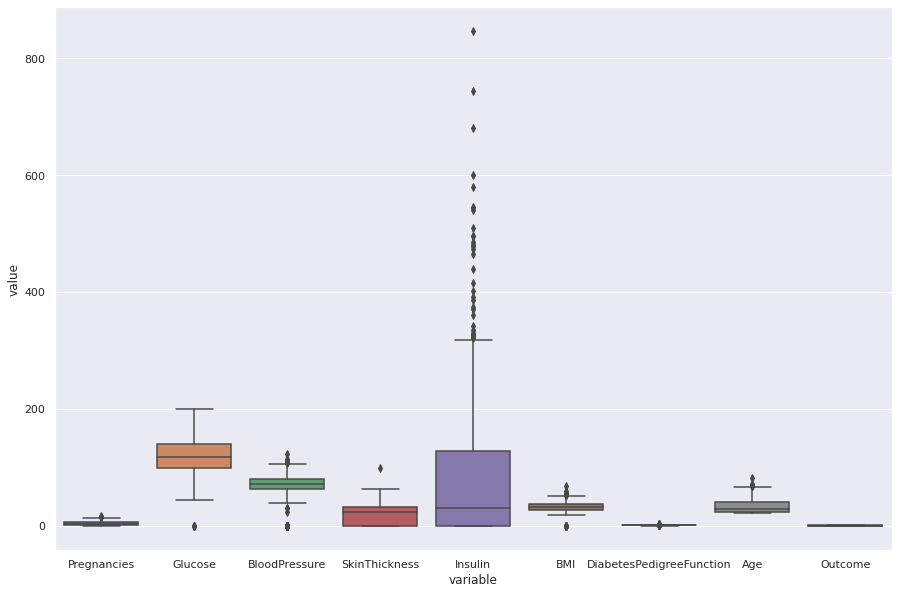

In [8]:
f, ax = plt.subplots(figsize = (15, 10)) # set size of the plot

sns.boxplot(x = "variable", y = "value", data = pd.melt(data), ax = ax) # use box plot to visualize outliers
plt.show() # display plot

In [9]:
def handleOutliers(data):
  Q1 = data.quantile(0.25) # calculate first quantile
  Q3 = data.quantile(0.75) # calculate third quantile
  IQR1 = Q3-Q1 # calculate inter quartile range

  data_c = data[~((data < (Q1-1.5*IQR1))|(data > (Q3+1.5*IQR1))).any(axis = 1)] # initialise data w/o outliers (drop outliers)

  print('Data loss is {}%'.format(((len(data) - len(data_c))/len(data))*100)) # report data loss
  return data_c.reset_index(drop = True)

In [10]:
data = handleOutliers(data) # drop outliers

2021-10-04 09:25:41,568 [INFO]  NumExpr defaulting to 2 threads.


Data loss is 16.796875%


In [11]:
def countMissing(data, col):
  return len(data[data[col] == 0]) # return count of missing values in column col

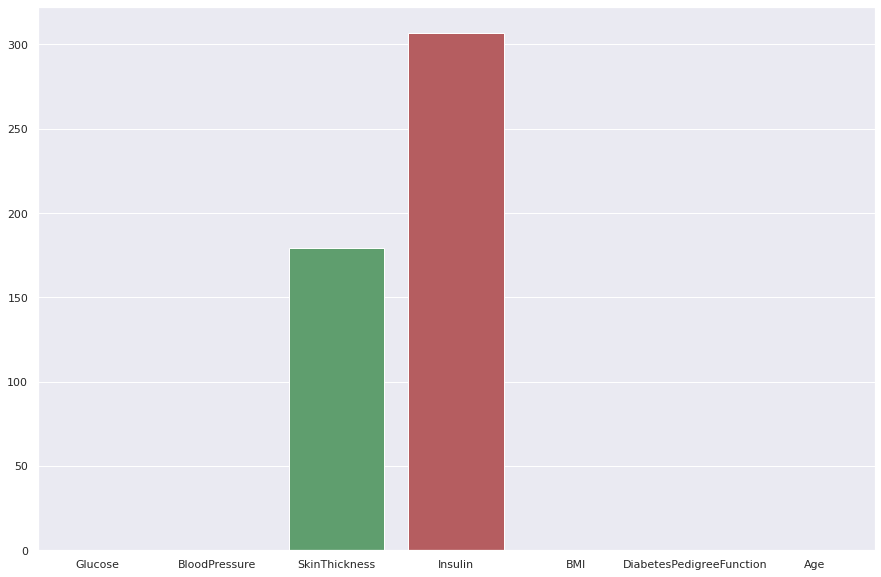

In [12]:
cols = list(data.columns)[1:-1] # columns check for missing values
missing_counts = [] # count of missing values

# for each column in columns
for col in cols:
  missing_counts.append(countMissing(data, col))

f, ax = plt.subplots(figsize = (15, 10)) # set size of the plot

sns.barplot(x = cols, y = missing_counts) # plot bar plot
plt.show() # display plot

In [13]:
# function to impute missing values in a given column
def impute(data, input_columns, column):
  #using simple imputer method
  imputer = datawig.SimpleImputer(
      input_columns = input_columns, # use ip_columns for imputation
      output_column = column
  )

  #fit data
  imputer.fit(data[data[column]!=0])

  # impute missing values
  imputed = imputer.predict(data[data[column] == 0])

  index = imputed.index # index of imputed values
  # replace values in data
  for i in index:
    data.at[i, column] = imputed.at[i, (column + "_imputed")]
  
  return data

In [14]:
# columns to use as input to impute missing values of features
input_columns = list(np.array(data.columns)[(np.array(data.columns) != "SkinThickness") & (np.array(data.columns) != "Insulin")][:-1])

# impute missing values for SkinThickness column
data_c = impute(data, input_columns, "SkinThickness")

# impute missing values for Insulin column
data_c = impute(data, input_columns, "Insulin")

data = data_c

2021-10-04 09:25:41,933 [INFO]  
========== start: fit model
2021-10-04 09:25:41,935 [WARNING]  Already bound, ignoring bind()
2021-10-04 09:25:41,962 [INFO]  Epoch[0] Batch [0-13]	Speed: 10652.07 samples/sec	cross-entropy=10.380099	SkinThickness-accuracy=0.000000
2021-10-04 09:25:41,983 [INFO]  Epoch[0] Train-cross-entropy=10.223893
2021-10-04 09:25:41,985 [INFO]  Epoch[0] Train-SkinThickness-accuracy=0.000000
2021-10-04 09:25:41,987 [INFO]  Epoch[0] Time cost=0.048
2021-10-04 09:25:41,992 [INFO]  Saved checkpoint to "skinthickness/model-0000.params"
2021-10-04 09:25:41,997 [INFO]  Epoch[0] Validation-cross-entropy=11.279492
2021-10-04 09:25:41,999 [INFO]  Epoch[0] Validation-SkinThickness-accuracy=0.000000
2021-10-04 09:25:42,025 [INFO]  Epoch[1] Batch [0-13]	Speed: 9724.08 samples/sec	cross-entropy=8.496121	SkinThickness-accuracy=0.000000
2021-10-04 09:25:42,050 [INFO]  Epoch[1] Train-cross-entropy=8.919505
2021-10-04 09:25:42,052 [INFO]  Epoch[1] Train-SkinThickness-accuracy=0.0000

In [15]:
y = data['Outcome'] #target variable
X = data.drop('Outcome', axis = 1) #predictors

# split data into train (90%) and test(10%) set
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X, y, test_size = 0.1, random_state = 1)

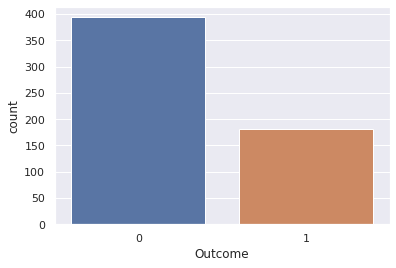

In [16]:
sns.countplot(x = Ytrain)

plt.show()

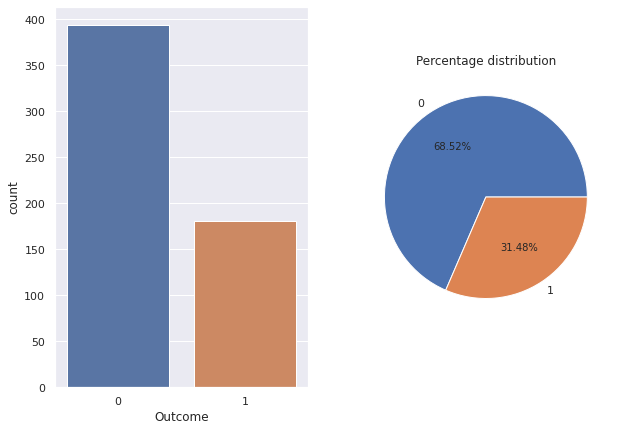

In [17]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 7)) # set up plot 

# visualise distribution in Ytrain

sns.countplot(x = Ytrain, ax = ax[0]) # plot bar plot

# plot a pie chart
ax[1].pie(x = Ytrain.value_counts().values, labels = Ytrain.value_counts().index, autopct = "%.2f%%")
ax[1].set_title("Percentage distribution") # set title

# display plots
plt.show()

In [18]:
#oversample considering 5 nearest neighbours such that |outcome=1|/|outcome=0| = 3/7
smote = SMOTE(sampling_strategy = 1, k_neighbors = 5, random_state = 9)
under = RandomUnderSampler(sampling_strategy = 1, random_state = 9) #undersample such that |outcome=1|/|outcome=0| = 0.5

Xtrain, Ytrain = smote.fit_resample(Xtrain, Ytrain) #apply oversampling
Xtrain, Ytrain = under.fit_resample(Xtrain, Ytrain) #apply undersampling

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [19]:
print('Class \tDistribution\n1\t', len(Ytrain[Ytrain==1])/len(Ytrain)*100, '% \n0\t', len(Ytrain[Ytrain==0])/len(Ytrain)*100, '%')

Class 	Distribution
1	 50.0 % 
0	 50.0 %


In [20]:
scaler = StandardScaler() #scaler processor

Xtrain = scaler.fit_transform(Xtrain) #Standardize features by removing the mean and scaling to unit variance
Xtest = scaler.transform(Xtest) #apply standardisation to test data

**Applying Machine Learning**

In [21]:
params = {'C' : [0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]} # values of C parameter in LR to try for

clf_lr = GridSearchCV(LogisticRegression(), params) # Logistic Regression

clf_lr.fit(Xtrain, Ytrain) # train LR model

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005,
                               0.01, 0.03, 0.05, 0.1, 0.3, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
def getF1Score(clf, Ytest, Xtest):
  return f1_score(Ytest, clf.predict(Xtest))

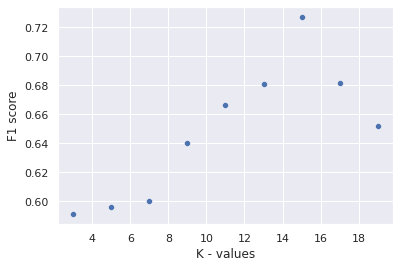

In [23]:
knn_au_y = [] # to store k values
knn_au_x = [] # to store AUPRC score corresponding to k values

# loop over every odd integer from 3 to 21 and use it as n_neighbors in Knn
for k in range(3, 21, 2): 
  clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean') #set up KNN model
  clf.fit(Xtrain, Ytrain) #fit model
  knn_au_y.append(getF1Score(clf, Ytest, Xtest)) #append AUPRC score
  knn_au_x.append(k) #append K value

sns.scatterplot(x = knn_au_x, y = knn_au_y) #scatterplot

plt.ylabel("F1 score") # label y-axis 'AUPRC score'
plt.xlabel("K - values") # label x-axis 'Algorithms'

plt.show() # display plot

In [24]:
clf_knn = KNeighborsClassifier(n_neighbors=15, metric='euclidean') # using K = 15 
clf_knn.fit(Xtrain, Ytrain) #fit model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [25]:
clf_rf = RandomForestClassifier() # Random Forest Classifier
clf_rf.fit(Xtrain, Ytrain) # train RF clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

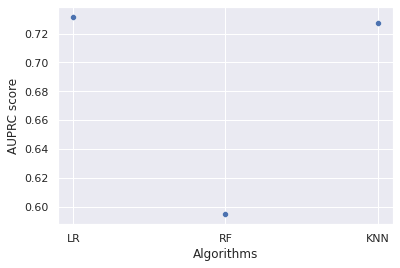

In [26]:
plotX = ["LR", "RF", "KNN"] # datapoints for x-axis of plot 
plotY = [getF1Score(clf_lr, Ytest, Xtest), getF1Score(clf_rf, Ytest, Xtest), getF1Score(clf_knn, Ytest, Xtest)] # datapoints for y-axis of plot

sns.scatterplot(x = plotX, y = plotY) #scatterplot

plt.ylabel("AUPRC score") # label y-axis 'AUPRC score'
plt.xlabel("Algorithms") # label x-axis 'Algorithms'

plt.show() # display plot

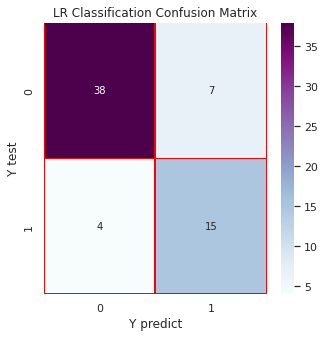

In [27]:
f, ax = plt.subplots(figsize=(5,5)) #set up plot

logreg_cm = confusion_matrix(Ytest, clf_lr.predict(Xtest)) # calculate confusion matrix
sns.heatmap(logreg_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu") #plot a heatmap using seaborn

plt.title('LR Classification Confusion Matrix') # set title to plot
#set labels to plot
plt.xlabel('Y predict')
plt.ylabel('Y test')

plt.show() #display plot

In [28]:
print("Accuracy obtained using LR classifier is : {}%".format(100*clf_lr.score(Xtest, Ytest)))

Accuracy obtained using LR classifier is : 82.8125%


**Applying Deep Learing**

In [29]:
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [30]:
inputs = Input(name='inputs', shape=[Xtrain.shape[1],])
layer = Dense(128, name='FC1')(inputs)
layer = BatchNormalization(name='BC1')(layer)
layer = Activation('relu', name='Activation1')(layer)
layer = Dropout(0.3, name='Dropout1')(layer)
layer = Dense(128, name='FC2')(layer)
layer = BatchNormalization(name='BC2')(layer)
layer = Activation('relu', name='Activation2')(layer)
layer = Dropout(0.3, name='Dropout2')(layer)
layer = Dense(128, name='FC3')(layer)
layer = BatchNormalization(name='BC3')(layer)
layer = Dropout(0.3, name='Dropout3')(layer)
layer = Dense(1, name='OutLayer')(layer)
layer = Activation('sigmoid', name='sigmoid')(layer)
model = Model(inputs=inputs, outputs=layer)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 8)]               0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               1152      
_________________________________________________________________
BC1 (BatchNormalization)     (None, 128)               512       
_________________________________________________________________
Activation1 (Activation)     (None, 128)               0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
BC2 (BatchNormalization)     (None, 128)               512   

In [36]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [37]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=[get_f1])

In [38]:
reduce_lr = ReduceLROnPlateau()
early_stopping = EarlyStopping(patience=20, min_delta=0.0001)

In [41]:
model.fit(x=Xtrain, y=Ytrain, epochs=200, validation_data=(Xtest, Ytest), callbacks=[reduce_lr, early_stopping])

Epoch 1/200
25/25 [==============================] - 0s 6ms/step - loss: 0.4268 - get_f1: 0.8106 - val_loss: 0.4328 - val_get_f1: 0.6842
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4133 - get_f1: 0.8256 - val_loss: 0.4314 - val_get_f1: 0.6684
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4120 - get_f1: 0.8155 - val_loss: 0.4303 - val_get_f1: 0.6684
Epoch 4/200
25/25 [==============================] - 0s 4ms/step - loss: 0.3843 - get_f1: 0.8278 - val_loss: 0.4280 - val_get_f1: 0.6684
Epoch 5/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4077 - get_f1: 0.8167 - val_loss: 0.4284 - val_get_f1: 0.6684
Epoch 6/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4119 - get_f1: 0.8169 - val_loss: 0.4284 - val_get_f1: 0.6684
Epoch 7/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4045 - get_f1: 0.8080 - val_loss: 0.4295 - val_get_f1: 0.6684
Epoch 8/200
25/25 [======================

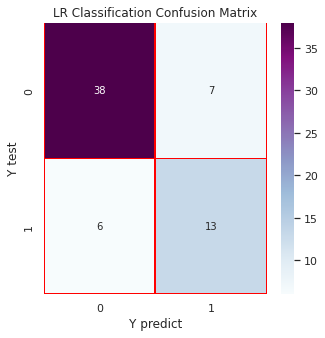

In [56]:
f, ax = plt.subplots(figsize=(5,5)) #set up plot

logreg_cm = confusion_matrix(Ytest, Y_pred) # calculate confusion matrix
sns.heatmap(logreg_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu") #plot a heatmap using seaborn

plt.title('LR Classification Confusion Matrix') # set title to plot
#set labels to plot
plt.xlabel('Y predict')
plt.ylabel('Y test')

plt.show() #display plot

In [55]:
Y_pred = (((model.predict(Xtest)>0.5).astype('int32')).reshape(1, -1))[0]

In [67]:
def get_accuracy(Ytest, Ypred):
  return np.sum(np.array(Ytest == Ypred))/len(Ytest)

In [69]:
print("Accuracy obtained using LR classifier is : {}%".format(100*get_accuracy(Ytest, Y_pred)))

Accuracy obtained using LR classifier is : 79.6875%
